In [1]:
#This notebook is intended to design/test chess representations for their use in training Basilisk
import chess #python-chess and python in general is not optimal for creating chess engines, but the goal of this project
# is to produce a chess Neural Network that is high performing. Thus, we will mainly be testing the neural network rather than
# optimizing some kind of tree search.
import numpy as np
import env

import keras

from keras.models import Model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, Dropout, AlphaDropout, Lambda
from keras.layers import GlobalAveragePooling2D, Multiply, Permute, Reshape
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.regularizers import l1, l2
from keras import backend as K
import tensorflow as tf


print(len(env.MOVES))

Using TensorFlow backend.


1968


In [2]:
class Invert(keras.layers.Layer):
    def __init__(self):
        super(Invert, self).__init__()
    
    def call(self, inputs):
        one = K.ones(1)
        return one - inputs

def stem(X, filters, stage="stem", size=3, lambd=0.0):
    stem = Conv2D(filters=filters, kernel_size=(size,size), strides=(1,1), padding='same', data_format='channels_last', 
                  name='Conv_' + stage, kernel_initializer=glorot_uniform(), kernel_regularizer=l2(lambd))(X)
    stem = BatchNormalization(axis=-1, trainable=True)(stem)
    stem = Activation('relu')(stem)
    return stem

def res_block(X, filters, block, size=3, lambd=0.0):
    res = Conv2D(filters=filters, kernel_size=(size,size), strides=(1,1), padding='same', data_format='channels_last', 
                name='res_block1_' + block, kernel_initializer=glorot_uniform(), kernel_regularizer=l2(lambd))(X)
    res = BatchNormalization(axis=-1, trainable=True)(res)
    res = Activation('relu')(res)
    res = Conv2D(filters=filters, kernel_size=(size,size), strides=(1,1), padding='same', data_format='channels_last', 
                name='res_block2_' + block, kernel_initializer=glorot_uniform(), kernel_regularizer=l2(lambd))(res)

    X = Add()([X, res])
    X = BatchNormalization(axis=-1, trainable=True)(X)
    X = Activation('relu')(X)
    return X

def create_model(filters, resblocks=5):
    lambd = 0.0
    
    image = Input(shape=(8, 8, 17)) #Chess representation
    
    #Stem
    X = stem(image, filters)
    
    #Resnet
    for i in range(resblocks):
        X = res_block(X, filters, str(i + 1))
    
    #Create latent representation
    latent = stem(X, 32, stage="latent", size=1)
    latent = Flatten()(latent)
    latent = Dense(64, activation="relu", name="latentspace", kernel_initializer=glorot_uniform())(latent)
    
    #Create state -> hidden state model
    fmodel = Model(inputs=image, outputs=latent)
    
    #Create policy and value function
    p = Dense(1968, activation="softmax", name="fcPolicy", kernel_initializer=glorot_uniform(), input_shape=(64,))
    v = Dense(1, activation="tanh", name="fcValue", kernel_initializer=glorot_uniform(), input_shape=(64,))
    
    #Create hidden state -> policy/value model
    prev_latent = Input(shape=(64,))
    pol = p(prev_latent)
    val = v(prev_latent)
    gmodel = Model(inputs=prev_latent, outputs=[pol, val])
    
    #Create full model
    policy = p(latent)
    value = v(latent)
    model = Model(inputs=image, outputs=[policy, value])
    
    #Create hidden state -> hidden state model for MCTS in hidden space
    p_latent = Input(shape=(64,))
    new_policy = Input(shape=(1968,))
    concat = Concatenate(axis=-1)([p_latent, new_policy])
    
    hidden = Dense(10, activation="relu")(concat)
    new_latent = Dense(64, activation="relu")(hidden)
    hmodel = Model(inputs=[p_latent, new_policy], outputs=new_latent)
    
    #Create updates for hmodel
    true_latent = K.placeholder(shape=(None, 64), name="truelatent")
    latent_MSE = K.sum(K.square(true_latent - new_latent), axis=1)
    L_h = K.mean(latent_MSE)
    
    opt_h = keras.optimizers.Adam(3e-3)
    updates_h = opt_h.get_updates(params=hmodel.trainable_weights, loss=L_h)
    train_fn_h = K.function(inputs=[hmodel.input[0], hmodel.input[1], true_latent],
                           outputs=[L_h], updates=updates_h)
    
    #full model training function
    p1 = K.clip(policy, K.epsilon(), 1)
    
    #placeholder
    target = K.placeholder(shape=(None, 1), name="target_value")
    expert = K.placeholder(shape=(None, 1968), name="expert_policy")
        
    MSE = K.mean(K.sum(K.square(target- value), axis=-1))
    y_true = K.clip(expert, K.epsilon(), 1)
    
    Lclip = -K.mean(K.sum(y_true * K.log(p1), axis=-1))
    
    loss = Lclip + 1.0*MSE
    
    c_print = Lclip
    v_print = MSE
    
    #optimizer
    opt = keras.optimizers.Adam(3e-3)
    updates = opt.get_updates(params=model.trainable_weights, loss=loss)
    train_fn = K.function(inputs=[model.input, expert, target], outputs=[c_print, v_print], updates=updates)
    
    model.summary()
    hmodel.summary()
    
    return model, fmodel, gmodel, hmodel, train_fn, train_fn_h

def create_NN():
    image = Input(shape=(8, 8, 17)) #Chess representation
    X = Flatten()(image)
    latent = Dense(64, activation="relu", name="latentspace", kernel_initializer=glorot_uniform())(X)

    #Create state -> hidden state model
    fmodel = Model(inputs=image, outputs=latent)

    #Create policy and value function
    p = Dense(1968, activation="softmax", name="fcPolicy", kernel_initializer=glorot_uniform(), input_shape=(64,))
    v = Dense(1, activation="tanh", name="fcValue", kernel_initializer=glorot_uniform(), input_shape=(64,))

    #Create hidden state -> policy/value model
    prev_latent = Input(shape=(64,))
    pol = p(prev_latent)
    val = v(prev_latent)
    gmodel = Model(inputs=prev_latent, outputs=[pol, val])

    #Create full model
    policy = p(latent)
    value = v(latent)
    model = Model(inputs=image, outputs=[policy, value])

    #Create hidden state -> hidden state model for MCTS in hidden space
    p_latent = Input(shape=(64,))
    new_policy = Input(shape=(1968,))
    concat = Concatenate(axis=-1)([p_latent, new_policy])

    hidden = Dense(10, activation="relu")(concat)
    new_latent = Dense(64, activation="relu")(hidden)
    hmodel = Model(inputs=[p_latent, new_policy], outputs=new_latent)

    #Create updates for hmodel
    true_latent = K.placeholder(shape=(None, 64), name="truelatent")
    latent_MSE = K.sum(K.square(true_latent - new_latent), axis=1)
    L_h = K.mean(latent_MSE)

    opt_h = keras.optimizers.Adam(3e-3)
    updates_h = opt_h.get_updates(params=hmodel.trainable_weights, loss=L_h)
    train_fn_h = K.function(inputs=[hmodel.input[0], hmodel.input[1], true_latent],
                           outputs=[L_h], updates=updates_h)

    #full model training function
    p1 = K.clip(policy, K.epsilon(), 1)

    #placeholder
    expert = K.placeholder(shape=(None, 1968), name="expert_policy")
    target = K.placeholder(shape=(None, 1), name="target_value")

    MSE = K.mean(K.sum(K.square(target- value), axis=-1))
    y_true = K.clip(expert, K.epsilon(), 1)

    Lclip = -K.mean(K.sum(y_true * K.log(p1), axis=-1))

    loss = Lclip + 1.0*MSE

    #optimizer
    opt = keras.optimizers.Adam(3e-5)
    updates = opt.get_updates(params=model.trainable_weights, loss=loss)
    train_fn = K.function(inputs=[model.input, expert, target], outputs=[Lclip, MSE], updates=updates)

    model.summary()
    hmodel.summary()

    return model, fmodel, gmodel, hmodel, train_fn, train_fn_h

In [66]:
model, fmodel, gmodel, hmodel, train_fn, train_h = create_NN()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 8, 8, 17)     0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 1088)         0           input_9[0][0]                    
__________________________________________________________________________________________________
fcPolicy (Dense)                (None, 1968)         2143152     flatten_4[0][0]                  
__________________________________________________________________________________________________
fcValue (Dense)                 (None, 1)            1089        flatten_4[0][0]                  
Total params: 2,144,241
Trainable params: 2,144,241
Non-trainable params: 0
_________________________________

In [3]:
#Save model method
def save_model(model, modelFile, weightFile): #Save model to json and weights to HDF5
    import keras
    from keras.models import model_from_json


    model_json = model.to_json()
    with open(modelFile, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(weightFile)
    print("Model saved!")
def load_model(modelFile, weightFile, update=True): #load model from json and HDF5
    import keras
    from keras.models import model_from_json


    json_file = open(modelFile, 'r')
    load_model_json = json_file.read()
    json_file.close()
    if not update:
        load_model = model_from_json(load_model_json)
    else:
        _, _, _, load_model, _, _ = create_model(64, resblocks=5)
        load_model.summary()
    load_model.load_weights(weightFile)
    print("Model Loaded!")
    return load_model

In [5]:
model = load_model("TinyBasilisk.json", "TinyBasilisk.h5", update=False)

Model Loaded!


In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 8, 17)     0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1088)         0           input_1[0][0]                    
__________________________________________________________________________________________________
latentspace (Dense)             (None, 64)           69696       flatten_1[0][0]                  
__________________________________________________________________________________________________
fcPolicy (Dense)                (None, 1968)         127920      latentspace[0][0]                
__________________________________________________________________________________________________
fcValue (D

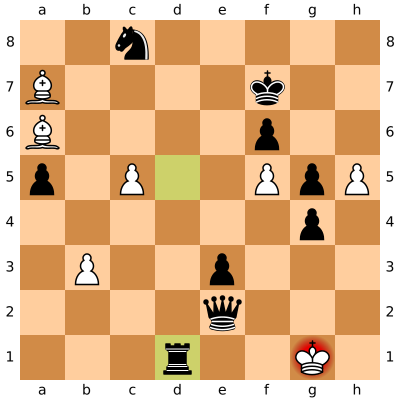

In [7]:
import chess.svg
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
#Simulate Game
ply_number = 1
board = chess.Board()
tau = 1.0
eval_graph = []
opening_book = ["e2e4", "d2d4", "c2c4", "g1f3"]
uci_index = np.random.choice(4)
uci_move = opening_book[uci_index]
board.push_uci(uci_move)
move_dict = env.generate_move_dict()

while not board.is_game_over():
    display(board)
    if ply_number <= 2: #Diversify openings
        tau = 0.5
    else:
        tau = 1.0
    ply_number += 1
    position = env.convert(board)
    position = np.reshape(position, [-1, 8, 8, 17])
    policy, value = model.predict(position)
    policy = np.squeeze(policy)
    eval_graph.append(np.squeeze(value))
    #Implement tau
    mask = env.fast_bitmask(board, move_dict)
    policy = policy * mask
    policy = np.power(policy, tau)
    policy = policy/np.sum(policy)
    index = np.random.choice(1968, p=policy)

    board.push_uci(env.MOVES[index])
    clear_output(wait=True)
    
plt.plot(eval_graph)
display(board)

In [8]:
import os
import chess.pgn

rand = np.random.randint(1, 100000)
game = chess.pgn.Game().from_board(board)
game.headers['Event'] = "Basilisk 401 Iterations"
game.headers['Site'] = 'Tau = 2.0 at <10 ply'
game.headers['Round'] = 'Test ID: ' + str(rand)
game.headers['White'] = "Basilisk"
game.headers['Black'] = "Basilisk"

name = "games/" + str(rand) + ".pgn"
directory = "games/"

try:
    os.mkdir(directory)
except FileExistsError:
    pass

new_pgn = open(name, "w", encoding="utf-8")
exporter = chess.pgn.FileExporter(new_pgn)
game.accept(exporter)

In [ ]:
from tqdm import tqdm
#Mass Simulate Games
games = 10

for _ in tqdm(range(games)):
    #Simulate Game
    ply_number = 1
    board = chess.Board()
    tau = 1.0
    opening_book = ["e2e4", "d2d4", "c2c4", "g1f3"]
    uci_index = np.random.choice(4)
    uci_move = opening_book[uci_index]
    board.push_uci(uci_move)
    while not board.is_game_over():
        if ply_number <= 10: #Diversify openings
            tau = 1.0
        else:
            tau = 1.0
        
        if ply_number >= 100:
            tau = 5.0
        ply_number += 1
        position = env.convert(board)
        position = np.reshape(position, [-1, 8, 8, 17])
        policy, value = model.predict(position)
        policy = np.squeeze(policy)
        #Implement tau
        mask = env.fast_bitmask(board, move_dict)
        policy = policy * mask
        policy = np.power(policy, tau)
        policy = policy/np.sum(policy)
        index = np.random.choice(1968, p=policy)

        board.push_uci(env.MOVES[index])
    
    rand = np.random.randint(1, 100000)
    game = chess.pgn.Game().from_board(board)
    game.headers['Event'] = "Basilisk 401 Iterations"
    game.headers['Site'] = 'Tau = 2.0 at <10 ply'
    game.headers['Round'] = 'Test ID: ' + str(rand)
    game.headers['White'] = "Basilisk"
    game.headers['Black'] = "Basilisk"

    name = "games/" + str(rand) + ".pgn"
    directory = "games/"

    try:
        os.mkdir(directory)
    except FileExistsError:
        pass

    new_pgn = open(name, "w", encoding="utf-8")
    exporter = chess.pgn.FileExporter(new_pgn)
    game.accept(exporter)

In [ ]:
tau = 1.0
board = chess.Board()
board.push_san("e4")
board.push_san("e5")
board.push_san("Nf3")
board.push_san("Nc6")
board.push_san("Bb5")
board.push_san("a6")
board.push_san("Bc4")
position = env.convert(board)
position = np.reshape(position, [-1, 8, 8, 17])
policy, value = model.predict(position)
policy = np.squeeze(policy)
display(board)
#Implement tau
move_dict = env.generate_move_dict()
mask = env.fast_bitmask(board, move_dict)
policy = policy * mask
policy = np.power(policy, tau)
policy = policy/np.sum(policy)
index = 0
print(value)
for prior in policy:
    if prior:
        print(env.MOVES[index], ": ", prior)
    
    index += 1

In [9]:
import numpy as np
from tqdm import tqdm

def muMCTS(board, turn, model, simulations=10000, dirichlet=False, alpha=10.0/(63.0), verbose=False):
    move_dict = env.generate_move_dict()
    
    if simulations == 0:
        pos = env.convert(board)
        pos = np.reshape(pos, [-1, 8, 8, 17])
        policy, value = model.predict(pos)
        mask = env.fast_bitmask(board, move_dict)
        policy = policy * mask
        policy = policy/np.sum(policy)
        return policy, value
    
    pos = env.convert(board)
    pos = np.reshape(pos, [-1, 8, 8, 17])
    policy, init_value = model.predict(pos)
    mask = env.fast_bitmask(board, move_dict)
    policy = policy * mask
    init_policy = policy/np.sum(policy)
    if dirichlet:
        dirich = np.random.dirichlet([alpha] * 1968)
        policy = (policy * 0.75) + (0.25 * dirich)
    root = init_root(board.copy(), policy, turn, np.squeeze(init_value), mask)
    
    for i in range(simulations):
        if verbose:
            print("Simulation: ", i)
            print(root)
            
        leaf_parent, leaf_board, action = root.leaf()
        
        uci_move = env.MOVES[action]
        new_board = leaf_board.copy()
        if new_board.is_game_over(): #or new_board.can_claim_draw():
            value = 0
            if board.is_checkmate():
                if board.turn:
                    value = -1.5
                else:
                    value = 1.5
            leaf_parent.backup(value)
        else:
            new_board.push_uci(uci_move)
            if new_board.is_game_over():
                value = 0
                if board.is_checkmate():
                    if board.turn:
                        value = -1.5
                    else:
                        value = 1.5
                policy = np.zeros(1968)
                leaf_parent.expand_backup(action, new_board, policy, value, policy)
            else:
                pos = env.convert(new_board)
                pos = np.reshape(pos, [-1, 8, 8, 17])
                policy, value = model.predict(pos)
                mask = env.fast_bitmask(new_board, move_dict)
                policy = policy * mask
                leaf_parent.expand_backup(action, new_board, policy, np.squeeze(value), mask)
            if verbose:
                clear_output(wait=True)

    #val = root.child_Q()[np.argmax(root.child_plays)] #Return the q value of our most visited node
    if verbose:
        print(root)
        
    return root.child_plays/np.sum(root.child_plays), root.child_Q(), init_policy

def init_root(hidden_state, policy, turn, fpu, mask): #Handle root case
    root = Node(None, 0, hidden_state, policy, turn, fpu, mask)
    return root

class Node:
    def __init__(self, parent, index, state, policy, turn, fpu, mask): #On init we need to define the parent and the index the node is in the parent child array
        self.parent = parent
        self.index = index
        self.turn = turn #Boolean to switch our pUCT conditions
        self.policy = policy
        self.state = state

        fpu_red = -1.0
        if not turn:
            fpu_red = 1.0

        self.mask = mask
        self.child_plays = np.zeros([1968], dtype=np.int32) #Keep track of how many times our children have played
        self.child_values = np.full([1968], np.clip(fpu_red, -1, 1), dtype=np.float32) #Keep track of the sum of q values

        self.children = [None]*1968 #A list of children, there will 1924 of them.. no python chess to tell us less children

    def child_Q(self): #return average Q-values
        values = self.child_values
        if self.turn:
            values = (1-self.mask)*-100 + values
        else:
            values = (1-self.mask)*100 + values
            
        return values / (1 + self.child_plays)

    def child_U(self): #return puct bound
        #DEFINE HYPERPARAMETERS HERE
        c1 = 2.5
        c2 = 19652

        #Define sum of plays among the children
        total_plays = np.sum(self.child_plays)
        u = (c1 + np.log((total_plays + c2 + 1)/c2)) * np.sqrt(total_plays + 1) / (1 + self.child_plays)
        return self.policy * u

    def pUCT_child(self): #Returns state action pair (s', a)
        #print("calc puct")
        if self.turn: #CT
            child_index = np.argmax(self.child_Q() + self.child_U())
            return self.children[child_index], child_index
        else: #T
            child_index = np.argmin(self.child_Q() - self.child_U())
            return self.children[child_index], child_index

    def leaf(self, depth_max=10):
        #print("finding leaf")
        current = self
        parent = self
        depth = 0
        while current is not None:
            parent = current
            current, action = current.pUCT_child()
            depth += 1
        return parent, parent.state, action #Action must be converted to one-hot or other formatting in search function

    def expand_backup(self, index, new_state, policy, value, mask): #Create a child at index with state and policy
        #print("expanding")
        child = Node(self, index, new_state, policy, not self.turn, value, mask)
        self.children[index] = child
        self.child_values[index] = value
        self.child_plays[index] += 1
        self.backup(value)

    def backup(self, value):
        #print("backing")
        current = self
        while current.parent != None:
            current.parent.child_values[current.index] += value
            current.parent.child_plays[current.index] += 1
            current = current.parent
    
    def __repr__(self, level=0, norm=0, play=0): #Print tree
        if norm == 0:
            norm = np.sum(self.child_plays)
            play = norm
            
        norm_plays = self.child_plays/norm
        top_norm = np.sum(self.child_plays)
        
        act = env.MOVES[self.index]
        
        ret = "\t"*level+act+"("+str(self.index)+"): "+str(play)+"\n"
        for child in self.children:
            if child is not None:
                if norm_plays[child.index] >= 0.02:
                    ret += child.__repr__(level=level+1, norm=norm, play=self.child_plays[child.index])
        return ret


In [ ]:
from tqdm import tqdm
import os
import chess.pgn
import chess.svg
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

#Mass Simulate Games
games = 1000
simulations = 800
for _ in range(games):
    #Simulate Game
    ply_number = 100
    board = chess.Board()
    tau = 1.0
    opening_book = ["e2e4", "d2d4", "c2c4", "g1f3"]
    uci_index = np.random.choice(4)
    uci_move = opening_book[uci_index]
    board.push_uci(uci_move)
    while not (board.is_game_over() or board.can_claim_draw()):
        display(board)
        if ply_number <= 3: #Diversify openings
            tau = 1.0
        else:
            tau = 5.0
        
        if ply_number >= 200:
            break
        ply_number += 1
        
        policy, value, _ = muMCTS(board, board.turn, model, simulations=simulations)
        policy = np.squeeze(policy)
        policy = np.power(policy, tau)
        policy = policy/np.sum(policy)
        #Implement tau
        index = np.random.choice(1968, p=policy)

        board.push_uci(env.MOVES[index])
        clear_output(wait=True)
    
    rand = np.random.randint(1, 100000)
    game = chess.pgn.Game().from_board(board)
    game.headers['Event'] = "Basilisk 100 Iterations"
    game.headers['Site'] = 'Tau = 5.0 at >10 ply'
    game.headers['Round'] = 'Test ID: ' + str(rand)
    game.headers['White'] = "Basilisk"
    game.headers['Black'] = "Basilisk"

    name = "games/" + str(rand) + ".pgn"
    directory = "games/"

    try:
        os.mkdir(directory)
    except FileExistsError:
        pass

    new_pgn = open(name, "w", encoding="utf-8")
    exporter = chess.pgn.FileExporter(new_pgn)
    game.accept(exporter)


In [10]:
simulations = 10000
board = chess.Board()
#policy, value, _ = muMCTS(board, board.turn, model, simulations=simulations, verbose=True)
board.push_san("e4")
board.push_san("e5")
board.push_san("Nf3")
board.push_san("Nc6")
board.push_san("Bb5")
board.push_san("a6")
board.push_san("Bc4")
policy, value, _ = muMCTS(board, board.turn, model, simulations=simulations, verbose=True)


a1b1(0): 10000
	c6a5(1205): 1246
		c4d5(728): 327
			g8f6(1755): 293
		c4f7(736): 288
			e8e7(1710): 287
	d7d5(1469): 364
		c4d5(728): 298
	d8f6(1682): 986
		b1c3(36): 237
		d2d4(293): 250
	d8e7(1686): 209
	f8b4(1724): 315
	f8c5(1726): 737
		b1c3(36): 435
			g8f6(1755): 226
	f8d6(1728): 306
	f8e7(1734): 1406
		b1c3(36): 530
			g8f6(1755): 479
				c4d5(728): 237
		c4d5(728): 604
			g8f6(1755): 543
				b1c3(36): 265
	g8f6(1755): 3624
		b1c3(36): 1582
			f6e4(1300): 269
			f8b4(1724): 590
			f8e7(1734): 332
		e1g1(102): 253
		d2d3(288): 248
		d2d4(293): 298
		c4d3(716): 270
		c4d5(728): 217
		c4f7(736): 465
			e8e7(1710): 464
				e1g1(102): 236
	g8e7(1758): 405
		b1c3(36): 218



In [11]:
def get_key(brd):
    return str(brd) + str(brd.turn) + str(brd.has_legal_en_passant())


def search(board, depth, alpha, beta, white, move_dict, table, verbose=False, width=5, d_u=0):
    #MAX = np.min([3, depth + 1])
    if board.is_game_over():
        if board.is_checkmate():
            if board.turn:
                return -1.5
            else:
                return 1.5
        else:
            return 0.0
    
    #if board.can_claim_draw():
    #    return 0.0
    
    order = []
    moves = []
    value = 0
    key = get_key(board)
    try:
        moves, order, value = table[key]
        if verbose:
            print("table hit")
    except:
        pos = env.convert(board)
        pos = np.reshape(pos, [-1, 8, 8, 17])
        p, value = model.predict(pos)
        #mask = env.fast_bitmask(board, move_dict)
        #mask_sum = np.sum(mask)
        value = value[0][0]
        p_sum = 0
        for i in range(1968):
            if p[0][i] >= 0.0001:
                p_sum  += p[0][i]
                order.append(p[0][i])
                moves.append(env.MOVES[i])
            
            if p_sum >= 0.9:
                break
        
        order = np.argsort(-np.array(order))
    #print(order)
    new_values = np.zeros(len(moves))
    
    if depth == 0:
        """
        positions = []
        unravel(board, depth, positions)
        positions = np.reshape(positions, [-1, 8, 8, 17])
        _, values = model.predict(positions)
        value = 0.0
        if d_u % 2 == 1:
            if white:
                value = np.max(values)
            else:
                value = np.min(values)
        else:
            if white:
                value = np.min(values)
            else:
                value = np.max(values)
        """
        table[key] = (moves, order, value)
        return value
    
    
    new_depth = depth - 1
    if white:
        if value + 0.351 < alpha:
            return value
        elif value + 0.01 < alpha:
            new_depth = np.max([new_depth - 1, 0])
            
        maxVal = -2.0
        for i in range(len(order)):
            #cutoff = np.max([alpha, value-0.1])
            
            move = moves[order[i]]
            try:
                board.push_uci(move)
            except: #NN doesn't understand the position
                new_values[order[i]] = -2.0
                continue
            if verbose:
                print("->"*depth + " " + move)
                
            val = search(board, new_depth, alpha, beta, False, move_dict, table, verbose=verbose, width=width)
            new_values[order[i]] = val
            maxVal = np.max([val, maxVal])
            alpha = np.max([alpha, val])
            board.pop()
            #clear_output(wait=True)
            if beta <= alpha:
                break
        new_values = np.argsort(-new_values)
        table[key] = (moves, new_values, maxVal)
        return maxVal
    else:
        if value - 0.351 > beta:
            return value
        elif value - 0.01 > beta:
            new_depth = np.max([new_depth - 1, 0])
        
        minVal = +2.0
        for i in range(len(order)):
            #cutoff = np.min([beta, value+0.1])
            move = moves[order[i]]
            try:
                board.push_uci(move)
            except:
                new_values[order[i]] = 2.0
                continue
            if verbose:
                print("->"*depth + " " + move)
            val = search(board, new_depth, alpha, beta, True, move_dict, table, verbose=verbose, width=width)
            new_values[order[i]] = val
            minVal = np.min([val, minVal])
            beta = np.min([beta, val])
            #clear_output(wait=True)
            board.pop()
            if beta <= alpha:
                break
        
        new_values = np.argsort(new_values)
        table[key] = (moves, new_values, minVal)
        return minVal

def policy_s(board, depth, table, verbose=False):
    #MAX = np.min([4, depth + 1])
    move_dict = env.generate_move_dict()
    if board.is_game_over() or board.can_claim_draw():
        print("Game Over")
        return None
    
    order = []
    moves = []
    value = 0
    key = get_key(board)
    try:
        moves, order, value = table[key]
        if verbose:
            print("table hit")
    except:
        pos = env.convert(board)
        pos = np.reshape(pos, [-1, 8, 8, 17])
        p, value = model.predict(pos)
        mask = env.fast_bitmask(board, move_dict)
        mask_sum = np.sum(mask)
        
        count = 0
        for i in range(1968):
            if mask[i] == 1:
                order.append(p[0][i])
                moves.append(env.MOVES[i])
                count += 1
            
            if count == int(mask_sum):
                break
        
        order = np.argsort(-np.array(order))
    #print(order)
    new_values = np.zeros(len(moves))
    
    best_move = None
    white = board.turn
    best_val = -2.0
    if not white:
        best_val = 2.0
    
    
    pol = {}
    for i in range(len(order)):
        move = moves[order[i]]
        try:
            board.push_uci(move)
        except:
            if white:
                new_values[order[i]] = 2.0
            else:
                new_values[order[i]] = -2.0
            continue
        
        if verbose:
            print("->"*depth + " " + move)
        if white:
            #beta = np.max([value, best_val])
            val = search(board, depth-1, best_val, 2.0, False, move_dict, table, verbose=verbose)
            new_values[order[i]] = val
            pol[move] = val
            if best_val < val:
                best_val = val
                best_move = move
        else:
            #beta = np.min([value, best_val])
            val = search(board, depth-1, -2.0, best_val, True, move_dict, table, verbose=verbose)
            new_values[order[i]] = val
            pol[move] = val
            if best_val > val:
                best_val = val
                best_move = move
        i += 1
        board.pop()
    
    if white:
        new_values = np.argsort(-new_values)
    else:
        new_values = np.argsort(new_values)
        
    table[key] = (moves, new_values, best_val)
        
    return best_move, best_val, pol

def unravel(board, depth, positions):
    if depth == 1:
        for move in board.legal_moves:
            board.push(move)
            pos = env.convert(board)
            positions.append(pos)
            board.pop()
    else:
        for move in board.legal_moves:
            board.push(move)
            unravel(board, depth-1, positions)
            board.pop()

In [13]:
from time import time
t0 = time()
for _ in range(10000):
    pos = env.convert(board)
    pos = np.reshape(pos, [-1, 8, 8, 17])
    p, value = model.predict(pos)
t = time() - t0
#print(len(table))
print(t)

13.141968965530396


In [15]:
from time import time
def ID(board, max_depth, table, verbose=True, min_depth=2):
    for i in range(max_depth+1-min_depth):
        d = i + min_depth
        t0 = time()
        best_move, best_val, pol = policy_s(board, d, table, verbose=verbose)
        t = time() - t0
        print("Depth ", d)
        print("Time: ", t)
        print("Best Move: ", best_move)
        print("Best Value: ", best_val)
        print("Table Size: ", len(table))
        print(pol)
    
    return table, best_move, best_val


In [ ]:
table = {}
board = chess.Board()
board.push_uci("e2e4")
board.push_uci("e7e5")
board.push_uci("g1f3")
board.push_uci("b8c6")
board.push_uci("f1c4")
board.push_uci("g8f6")
board.push_uci("d2d4")
board.push_uci("e5d4")
board.push_uci("b1c3")
board.push_uci("d4c3")
board.push_uci("e1g1")
board.push_uci("f6e4")
board.push_uci("c4f7")
board.push_uci("e8f7")
table, best_move, best_val = ID(board, 100, table, verbose=False, min_depth=2)

Depth  2
Time:  0.4110894203186035
Best Move:  b2c3
Best Value:  -0.6961351633071899
Table Size:  101
{'b2c3': -0.6961351633071899, 'f1e1': -0.7300107479095459, 'a2a3': -0.7409182786941528, 'b2b3': -0.7173316478729248, 'f3d4': -0.8805999755859375, 'd1d3': -0.7191318273544312, 'd1e2': -0.7295007705688477, 'd1e1': -0.7525186538696289, 'a2a4': -0.7284563779830933, 'b2b4': -0.728108286857605, 'f3g5': -0.8438099026679993, 'h2h3': -0.7410265207290649, 'c1e3': -0.7257055044174194, 'f3d2': -0.7279794216156006, 'f3e5': -0.8569999933242798, 'h2h4': -0.7384456396102905, 'c1f4': -0.73167884349823, 'd1d2': -0.7328011393547058, 'd1d5': -0.7172837257385254, 'd1d4': -0.7194346189498901, 'c1g5': -0.743622899055481, 'a1b1': -0.721871018409729, 'g2g3': -0.7670632600784302, 'c1d2': -0.7262300252914429, 'f3h4': -0.7592364549636841, 'd1d7': -0.9379634261131287, 'f3e1': -0.7228657603263855, 'c1h6': -0.7157118320465088, 'd1d6': -0.7337706089019775, 'g2g4': -0.7710973620414734, 'g1h1': -0.7430920004844666}
Dep

{}


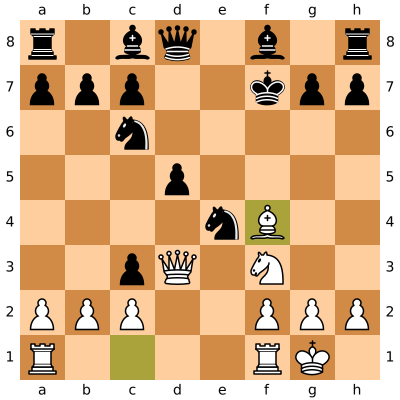

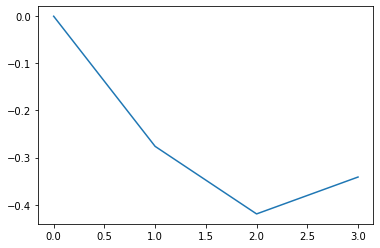

Depth  2
Time:  0.5251517295837402
Best Move:  c3b2
Best Value:  -0.5280392169952393
Table Size:  43765
{'c3b2': -0.5280392169952393, 'h7h5': -0.10435884445905685, 'g7g6': -0.11813819408416748, 'g7g5': -0.32523611187934875, 'f7g8': -0.1544797420501709, 'f7e7': 0.023977410048246384, 'f7g6': -0.013995252549648285, 'f7f6': -0.34569332003593445, 'f7e6': -0.16261829435825348, 'b7b6': -0.41369155049324036, 'b7b5': -0.3891408443450928, 'h7h6': -0.06543432921171188, 'a8b8': -0.23612242937088013, 'd8e8': -0.18981973826885223, 'd8e7': -0.40781280398368835, 'd8d7': -0.4471738040447235, 'd8f6': -0.28811556100845337, 'd8d6': 0.1365765631198883, 'd8g5': -0.034098315984010696, 'd8h4': 0.1337205171585083, 'c8d7': -0.26799824833869934, 'c8e6': -0.36917898058891296, 'c8f5': -0.5159618258476257, 'c8g4': -0.32002636790275574, 'c8h3': -0.24492362141609192, 'a7a6': -0.295572966337204, 'e4f2': -0.30063876509666443, 'e4d2': -0.23229096829891205, 'e4g3': -0.03555185720324516, 'f8a3': -0.13886182010173798, 'e4c

KeyboardInterrupt: 

In [54]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

def human_move(board):
    try:
        san = input("Move: ")
        board.push_san(san)
    except:
        print("Invalid Move")
        human_move(board)
    
board = chess.Board()
game_val = [0.0]
board.push_uci("e2e4")
board.push_uci("e7e5")
#board.push_uci("g1f3")
#board.push_uci("b8c6")
board.push_uci("g1f3")
board.push_uci("b8c6")
board.push_uci("f1c4")
board.push_uci("g8f6")
board.push_uci("d2d4")
board.push_uci("e5d4")
board.push_uci("b1c3")
board.push_uci("d4c3")
board.push_uci("e1g1")
board.push_uci("f6e4")
board.push_uci("c4f7")
board.push_uci("e8f7")
pol = {}
table = {}
while not (board.is_game_over() or board.can_claim_draw()):
    display(board)
    plt.plot(game_val)
    plt.show()
    
    if not board.turn:
        #p, val, _ = batchMCTS(board, board.turn, model, simulations=200, 
                             #verbose=False, batch_cap=256, init_batch=256)
        #Implement tau
        #index = np.argmax(p)
        #board.push_uci(env.MOVES[index])
        #game_val.append(val[index])
        table, best_move, best_val = ID(board, 6, table, verbose=False, min_depth=2)
        game_val.append(best_val)
        board.push_uci(best_move)
    else:
        p, val, _ = batchMCTS(board, board.turn, model, simulations=5000, 
                              verbose=False, batch_cap=16, init_batch=16)
        #Implement tau
        index = np.argmax(p)
        board.push_uci(env.MOVES[index])
        game_val.append(val[index])
        #human_move(board)
        
    clear_output(wait=True)
    print(pol)
    

In [ ]:
display(board)


In [ ]:
rand = np.random.randint(1, 100000)
game = chess.pgn.Game().from_board(board)
game.headers['Event'] = "Basilisk 401 Iterations"
game.headers['Site'] = 'Tau = 2.0 at <10 ply'
game.headers['Round'] = 'Test ID: ' + str(rand)
game.headers['White'] = "Basilisk"
game.headers['Black'] = "Basilisk"

name = "games/" + str(rand) + ".pgn"
directory = "games/"

try:
    os.mkdir(directory)
except FileExistsError:
    pass

new_pgn = open(name, "w", encoding="utf-8")
exporter = chess.pgn.FileExporter(new_pgn)
game.accept(exporter)

In [ ]:
plt.plot(game_val)
plt.show()

In [ ]:
def super_search(board, depth, alpha, beta, white, move_dict, verbose=False, width=5, d_u=1):
    #MAX = np.min([3, depth + 1])
    if board.is_game_over():
        if board.is_checkmate():
            if board.turn:
                return -1.5
            else:
                return 1.5
        else:
            return 0.0
    
    #if board.can_claim_draw():
    #    return 0.0

    if depth == d_u:
        positions = []
        unravel(board, depth, positions)
        positions = np.reshape(positions, [-1, 8, 8, 17])
        _, values = model.predict(positions)
        value = 0.0
        if d_u % 2 == 1:
            if white:
                value = np.max(values)
            else:
                value = np.min(values)
        else:
            if white:
                value = np.min(values)
            else:
                value = np.max(values)
                
        return value
    
    pos = env.convert(board)
    pos = np.reshape(pos, [-1, 8, 8, 17])
    p, _ = model.predict(pos)
    mask = env.fast_bitmask(board, move_dict)
    #mask_sum = np.sum(mask)
    
    p = np.squeeze(p * mask)
    order = np.argsort(p)
    #print(order)
    
    if white:
        maxVal = -2.0
        for i in range(int(width)):
            if mask[order[-i-1]] == 0:
                break
            move = env.MOVES[order[-i-1]]
            board.push_uci(move)
            #display(board)
            if verbose:
                print("->"*depth + " " + move)
                
            val = super_search(board, depth-1, alpha, beta, False, move_dict, verbose=verbose, width=width)
            maxVal = np.max([val, maxVal])
            alpha = np.max([alpha, val])
            board.pop()
            #clear_output(wait=True)
            if beta <= alpha:
                break
        return maxVal
    else:
        minVal = +2.0
        for i in range(int(width)):
            if mask[order[-i-1]] == 0:
                break
            move = env.MOVES[order[-i-1]]
            board.push_uci(move)
            #display(board)
            if verbose:
                print("->"*depth + " " + move)
            val = super_search(board, depth-1, alpha, beta, True, move_dict, verbose=verbose, width=width)
            minVal = np.min([val, minVal])
            beta = np.min([beta, val])
            #clear_output(wait=True)
            board.pop()
            if beta <= alpha:
                break
        return minVal

def unravel(board, depth, positions):
    if depth == 1:
        for move in board.legal_moves:
            board.push(move)
            pos = env.convert(board)
            positions.append(pos)
            board.pop()
    else:
        for move in board.legal_moves:
            board.push(move)
            unravel(board, depth-1, positions)
            board.pop()

In [33]:
import numpy as np
from tqdm import tqdm
from time import time

def batchMCTS(board, turn, model, simulations=10000, dirichlet=False, alpha=10.0/(63.0), verbose=False, batch_cap=4096, init_batch=2):
    move_dict = env.generate_move_dict()
    if simulations == 0:
        pos = env.convert(board)
        pos = np.reshape(pos, [-1, 8, 8, 17])
        policy, value = model.predict(pos)
        mask = env.fast_bitmask(board, move_dict)
        policy = policy * mask
        policy = policy/np.sum(policy)
        return policy, value
    
    
    pos = env.convert(board)
    pos = np.reshape(pos, [-1, 8, 8, 17])
    policy, init_value = model.predict(pos)
    mask = env.fast_bitmask(board, move_dict)
    policy = np.clip(policy, 0.25, 1.0)
    policy = policy * mask
    policy = policy/np.sum(policy)
    
    
    init_policy = policy
    new_priors = np.power(policy, 1/1.0)
    policy = new_priors/np.sum(new_priors)
    if dirichlet:
        dirich = np.random.dirichlet([alpha] * 1968)
        policy = (policy * 0.75) + (0.25 * dirich)
    root = init_root_virtual(board.copy(), policy, turn, np.squeeze(init_value), mask)
    
    batch = init_batch
    
    
    loss = -1
    if not turn:
        loss = 1
        
    cs = np.arange(batch)
    cs = (cs/batch)*5
    for i in range(simulations):
        if verbose:
            print("Simulation: ", i)
            #print("Worker C's: ", cs)
            print(root)
        
        #Gather [batch] amount of leaves
        tuples = []
        positions = []
        super_mask = []
        tot_time = 0
        
        for k in range(batch):
            leaf_parent, leaf_board, action = root.virtual_leaf(loss, cs[k])
            uci_move = env.MOVES[action]
            new_board = leaf_board.copy()
            
            if new_board.is_game_over():# or new_board.can_claim_draw():
                value = 0
                if new_board.is_checkmate():
                    if new_board.turn:
                        value = -1.5
                    else:
                        value = 1.5
                leaf_parent.backup(value - loss)
            else:
                new_board.push_uci(uci_move)
                mask = env.fast_bitmask(new_board, move_dict)
                tuples.append((leaf_parent, new_board, action, mask))
                pos = env.convert(new_board)
                positions.append(pos)
                super_mask.append(mask)
            
        
        if len(positions) > 0:    
            positions = np.reshape(positions, [-1, 8, 8, 17])
            super_mask = np.reshape(super_mask, [-1, 1968])
            policy, values = model.predict(positions)
            policy = np.clip(policy, 0.1, 1)
            #policy = policy*super_mask
            for k in range(len(tuples)):
                leaf_parent, new_board, action, mask = tuples[k]
                pol = policy[k]
                val = values[k]
                if new_board.is_game_over(): #or new_board.can_claim_draw():
                    val = 0
                    if new_board.is_checkmate():
                        if new_board.turn:
                            val = -1.5
                        else:
                            val = 1.5
                            
                leaf_parent.expand_backup(action, new_board, pol, val - loss, mask)
            
        batch = np.min([batch*2, batch_cap])
        if verbose:
            clear_output(wait=True)
            #print("Leaf time: ", tot_time)
    #val = root.child_Q()[np.argmax(root.child_plays)] #Return the q value of our most visited node
    if verbose:
        print(root)
        
    return root.child_plays/np.sum(root.child_plays), root.child_Q(), init_policy

def init_root_virtual(hidden_state, policy, turn, fpu, mask): #Handle root case
    root = NodeV(None, 0, hidden_state, policy, turn, fpu, mask)
    return root

class NodeV:
    def __init__(self, parent, index, state, policy, turn, fpu, mask): #On init we need to define the parent and the index the node is in the parent child array
        self.parent = parent
        self.index = index
        self.turn = turn #Boolean to switch our pUCT conditions
        self.policy = policy
        self.state = state

        fpu_red = 1.0
        if not turn:
            fpu_red = -1.0

        self.mask = mask
        self.child_plays = np.zeros([1968], dtype=np.int32) #Keep track of how many times our children have played
        self.child_values = np.full([1968], np.clip(fpu_red, -1, 1), dtype=np.float32) #Keep track of the sum of q values

        self.children = [None]*1968 #A list of children, there will 1924 of them.. no python chess to tell us less children

    def child_Q(self): #return average Q-values
        values = self.child_values
        if self.turn:
            values = (1-self.mask)*-1000000 + values
        else:
            values = (1-self.mask)*10000000 + values
            
        return values / (1 + self.child_plays)

    def child_U(self, c1): #return puct bound
        #DEFINE HYPERPARAMETERS HERE
        c2 = 19652

        #Define sum of plays among the children
        total_plays = np.sum(self.child_plays)
        u = (c1 + np.log((total_plays + c2 + 1)/c2)) * np.sqrt(total_plays + 1) / (1 + self.child_plays)
        return self.policy * u

    def pUCT_child(self, c1): #Returns state action pair (s', a)
        #print("calc puct")
        if self.turn: #CT
            child_index = np.argmax(self.child_Q() + self.child_U(c1)*self.mask)
            return self.children[child_index], child_index
        else: #T
            child_index = np.argmin(self.child_Q() - self.child_U(c1)*self.mask)
            return self.children[child_index], child_index

    def leaf(self,c):
        #print("finding leaf")
        current = self
        parent = self
        while current is not None:
            parent = current
            current, action = current.pUCT_child(c)
            
        return parent, parent.state, action #Action must be converted to one-hot or other formatting in search function
    
    def virtual_leaf(self, loss, c):
        current = self
        parent = self
        while True:
            parent = current
            current, action = current.pUCT_child(c)
            if current is None:
                break
            #Virtual Loss
            parent.child_values[current.index] += loss
            parent.child_plays[current.index] += 1
            
        return parent, parent.state, action

    def expand_backup(self, index, new_state, policy, value, mask): #Create a child at index with state and policy
        #print("expanding")
        child = NodeV(self, index, new_state, policy, not self.turn, value, mask)
        self.children[index] = child
        self.child_values[index] += value
        self.backup(value)

    def backup(self, value):
        #print("backing")
        current = self
        while current.parent != None:
            current.parent.child_values[current.index] += value
            current = current.parent
    
    
    def __repr__(self, level=0, norm=0, play=0, value=0): #Print tree
        if norm == 0:
            norm = np.sum(self.child_plays)
            play = norm
            value = np.sum((self.child_values/(1 + self.child_plays))*self.mask)/np.sum(self.mask)
            
        norm_plays = self.child_plays/norm
        top_norm = np.sum(self.child_plays)
        
        act = env.MOVES[self.index]
        
        ret = "\t"*level+act+"("+str(self.index)+"): "+str(play)+ ", " + str(value) +"\n"
        for child in self.children:
            if child is not None:
                if norm_plays[child.index] >= 0.02:
                    ret += child.__repr__(level=level+1, norm=norm, play=self.child_plays[child.index], value=self.child_Q()[child.index])
        return ret

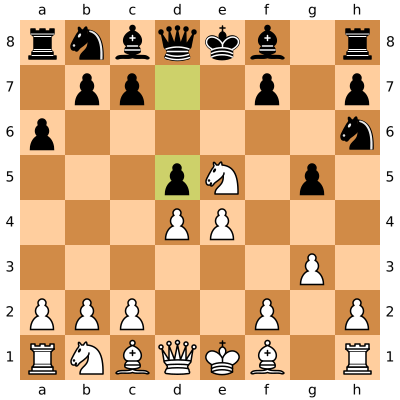

In [34]:
board.pop()
display(board)

In [41]:
simulations = 1500
#policy, value, _ = muMCTS(board, board.turn, model, simulations=simulations, verbose=True)
#board.push_uci("e4f2")
"""
board.push_uci("e2e4")
board.push_uci("e7e5")
board.push_uci("g1f3")
board.push_uci("b8c6")
board.push_uci("g8f6")
board.push_uci("d2d4")
board.push_uci("e5d4")
board.push_uci("b1c3")
board.push_uci("d4c3")
board.push_uci("e1g1")
board.push_uci("f6e4")
board.push_uci("c4f7")
board.push_uci("e8f7")
board.push_uci("d1d5")
"""
t0 = time()
leaves = 16
policy, value, _ = batchMCTS(board, board.turn, model, simulations=simulations, verbose=True, 
                             batch_cap=leaves, init_batch=leaves)
t1 = time() - t0
print(t1)
display(board)

Simulation:  854
a1b1(0): 13281, 0.2423849384063355
	b1d2(33): 272, 0.2639141991024926
	c1e3(63): 370, 0.2741819931811721
	c1g5(67): 2572, 0.3023866430312986
		d8g5(1677): 301, 0.24868673362479304
		d8e7(1686): 281, 0.24597595431280475
		f8e7(1734): 401, 0.24628192275317748
	d1d2(81): 401, 0.2768259760159165
	d1e2(82): 316, 0.2694982534703396
	f1e2(130): 266, 0.2630478648210733
	f1g2(132): 311, 0.269656010163136
	f1d3(134): 396, 0.27686844064246496
	f1c4(139): 322, 0.27026686063122823
	f1a6(143): 289, 0.2668007949302936
	h1g1(177): 783, 0.28917717447086255
	c2c4(264): 326, 0.27054574948932053
	e4d5(795): 400, 0.27639797144102635
	e5d3(1024): 433, 0.27906173495103687
	e5g6(1044): 287, 0.266292757458157
	e5f7(1048): 1001, 0.2904237910896956



KeyboardInterrupt: 

In [ ]:
def generate_move_dict():
    move_dict = {}
    i = 0
    for element in env.MOVES:
        move_dict[element] = i
        i += 1
    return move_dict

def fast_bitmask(board, dictionary):
    moves = np.zeros(1924)
    for move in board.legal_moves:
        key = board.uci(move)
        moves[dictionary[key]] = 1
    return moves

In [ ]:
move_dict = generate_move_dict()
board = chess.Board()


bit1 = fast_bitmask(board, move_dict)
t0 = time()
bit2 = env.legal_bitmask(board)
t1 = time()
print(t1-t0)

In [ ]:
from tqdm import tqdm
import os
import chess.pgn
import chess.svg
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

#Mass Simulate Games
games = 1000
simulations = 1000
for _ in range(games):
    #Simulate Game
    ply_number = 100
    board = chess.Board()
    tau = 1.0
    opening_book = ["e2e4", "d2d4", "c2c4", "g1f3"]
    uci_index = np.random.choice(4)
    uci_move = opening_book[uci_index]
    board.push_uci(uci_move)
    while not board.is_game_over():
        display(board)
        if ply_number <= 10: #Diversify openings
            tau = 1.0
        else:
            tau = 5.0
        
        if ply_number >= 200:
            break
        ply_number += 1
        
        policy, value, _ = batchMCTS(board, board.turn, model, simulations=simulations, verbose=False, batch_cap=128, init_batch=128)
        policy = np.squeeze(policy)
        #Implement tau
        index = np.argmax(policy)

        board.push_uci(env.MOVES[index])
        clear_output(wait=True)
    
    rand = np.random.randint(1, 100000)
    game = chess.pgn.Game().from_board(board)
    game.headers['Event'] = "Basilisk 100 Iterations"
    game.headers['Site'] = 'Tau = 5.0 at >10 ply'
    game.headers['Round'] = 'Test ID: ' + str(rand)
    game.headers['White'] = "Basilisk"
    game.headers['Black'] = "Basilisk"

    name = "games/" + str(rand) + ".pgn"
    directory = "games/"

    try:
        os.mkdir(directory)
    except FileExistsError:
        pass

    new_pgn = open(name, "w", encoding="utf-8")
    exporter = chess.pgn.FileExporter(new_pgn)
    game.accept(exporter)


In [ ]:
import chess.uci

stockfish = chess.uci.popen_engine("stockfish")
stockfish.uci()

In [ ]:
board = chess.Board()
while not (board.is_game_over() or board.can_claim_draw()):
    display(board)
    if board.turn:
        stockfish.position(board)
        stock_move = stockfish.go(movetime=100) #Set stockfish to 10 moves per second
        board.push(stock_move[0])
    else:
        human_move(board)
    clear_output(wait=True)